In [1]:
%matplotlib inline

# Imports

In [2]:
import numpy as np
import matplotlib.pylab as plt
import matplotlib.ticker as ticker
import matplotlib as mpl
import torch
import os
import sys
import pickle

import warnings
warnings.simplefilter("ignore", UserWarning)

In [3]:
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.append(project_root)

In [4]:
from Utilities import util
from Utilities.rand_generators import GridGenerator
from Utilities.normalization import zscore_normalization, zscore_unnormalization
from Prior_optimization.priors import OptimGaussianPrior, FixedGaussianPrior
from Samplers.likelihoods import LikGaussian
from Metrics.sampling import compute_rhat_regression
from Prior_optimization.optimisation_mapper import PriorOptimisationMapper
from Prior_optimization.wasserstein_mapper import MapperWasserstein
from Prior_optimization.gpr import GPR
from Prior_optimization.kernels import RBF, Exponential
from Prior_optimization.mean_functions import Zero
from Full_stochasticity.Networks.mlp import MLP
from Partial_stochasticity.Networks.factorized_gaussian_reparam_mlp import FactorizedGaussianMLPReparameterization
from Partial_stochasticity.Networks.regression_net_masked import RegressionNetMasked
from Partial_stochasticity.Networks.mlp_masked import MLPMasked
from Full_stochasticity.Networks.gaussian_reparam_mlp import GaussianMLPReparameterization
from Full_stochasticity.Networks.regression_net import RegressionNet
from Prior_optimization.mean_functions import Zero

In [5]:
os.chdir("..")

In [6]:
mpl.rcParams['figure.dpi'] = 100

In [7]:
OUT_DIR_PS = "./exp/1D_synthetic/partially_stochastic"
FIG_DIR_PS = os.path.join(OUT_DIR_PS, "figures")
util.ensure_dir(OUT_DIR_PS)
util.ensure_dir(FIG_DIR_PS)
OUT_DIR_FS = "./exp/1D_synthetic/fully_stochastic"
FIG_DIR_FS = os.path.join(OUT_DIR_FS, "figures")
util.ensure_dir(OUT_DIR_FS)
util.ensure_dir(FIG_DIR_FS)

In [8]:
# setting device on GPU if available, else CPU
n_gpu = 0
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device} \n')

#Additional Info when using cuda
if device.type == 'cuda':
    n_gpu += torch.cuda.device_count()
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')
    print('Number of available GPUs:', str(n_gpu))

Using device: cpu 



# Utilities

In [9]:
def make_random_gap(X, gap_ratio=0.2):
    a,b = X.min(),X.max()
    gap_a = a + np.random.rand() * (b-a)*(1-gap_ratio)
    gap_b = gap_a + (b-a)*gap_ratio
    idx = np.logical_and(gap_a<X, X<gap_b)
    if gap_a-a > b-gap_b:
        X[idx] = a + np.random.rand(idx.sum()) * (gap_a-a)
    else:
        X[idx] = gap_b + np.random.rand(idx.sum()) * (b-gap_b)

def gp_sample(X, ampl=1, leng=1, sn2=0.1):
    n, x = X.shape[0], X / leng
    sum_xx = np.sum(x*x, 1).reshape(-1, 1).repeat(n, 1)
    D = sum_xx + sum_xx.transpose() - 2 * np.matmul(x, x.transpose())
    C = ampl**2 * np.exp(-0.5 * D) + np.eye(n) * sn2
    return np.random.multivariate_normal(np.zeros(n), C).reshape(-1, 1)

def plot_samples(X, samples, var=None, n_keep=12, color="xkcd:bluish", smooth_q=False, ax=None):
    if ax is None: 
        ax = plt.gca()
    if samples.ndim > 2:
        samples = samples.squeeze()
    n_keep = int(samples.shape[1]/10) if n_keep is None else n_keep
    keep_idx = np.random.permutation(samples.shape[1])[:n_keep]
    mu = samples.mean(1)
    if var is None:
        q=97.72  ## corresponds to 2 stdevs in Gaussian
        # q = 99.99  ## corresponds to 3 std
        Q = np.percentile(samples, [100-q, q], axis=1)
        # ub, lb = Q[1,:], Q[0,:]
        ub, lb = mu + 2 * samples.std(1), mu - 2 * samples.std(1)
        if smooth_q:
            lb = moving_average(lb)
            ub = moving_average(ub)
    else:
        ub = mu + 3 * np.sqrt(var)
        lb = mu - 3 * np.sqrt(var)
    ####
    ax.fill_between(X.flatten(), ub, lb, color=color, alpha=0.25, lw=0)
    ax.plot(X, samples[:, keep_idx], color=color, alpha=0.8)
    ax.plot(X, mu, color='xkcd:red')

# Generate Data

In [10]:
util.set_seed(1)

N = 64
M = 100
a, b = -10, 10

# Generate data
X = np.random.rand(N, 1) * (b-a) + a
make_random_gap(X, gap_ratio=0.4)
y = gp_sample(X, ampl=1.6, leng=1.8)
Xtest = np.linspace(a-5, b+5, M).reshape(-1, 1)
# Normalize the dataset
X_, X_mean, X_std = zscore_normalization(X)
y_, y_mean, y_std = zscore_normalization(y)
Xtest_, _, _ = zscore_normalization(Xtest, X_mean, X_std)

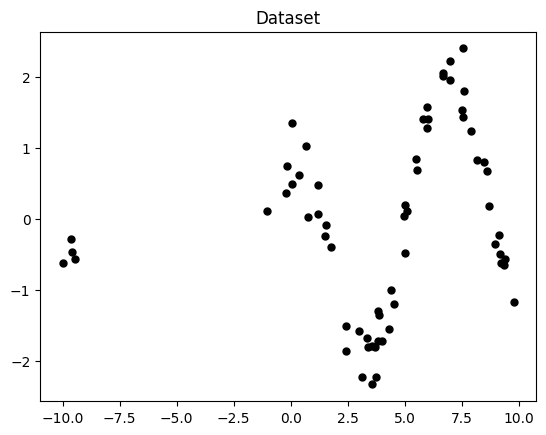

In [11]:
fig = plt.figure()
plt.plot(X, y, "ko", ms=5)
plt.title("Dataset")
plt.show()

In [12]:
Xtest_tensor = torch.from_numpy(Xtest_).to(device)

## Optimize the prior for partial stochasticity

In [13]:
# Configurations for the prior optimization
D = 3                                                       # The factorization depth
prior_opt_configurations = {
    "n_data": 200,                                          # The batch size 
    "num_iters": 5000,                                      # The number of iterations of the prior optimization
    "output_dim": 1,                                        # The dimension of the output
    "lambd": (torch.tensor([0.25, 0.5])/D).to(device),      # The regularization parameters for the layers
    "n_samples": 100,                                       # The number of function samples
    "lr": 5e-2,                                             # The learning rate for the optimizer
    "print_every": 100,                                     # After how many epochs a evaluation should be printed
    "save_ckpt_every": 500                                  # After how many epochs a checkpoint should be saved
}

In [14]:
# Network setup
util.set_seed(1)
width = 50              # Number of units in each hidden layer
depth = 2               # Number of hidden layers
transfer_fn = "tanh"    # Activation function
X_tensor = torch.from_numpy(X).float().to(device)
y_tensor = torch.from_numpy(y).float().to(device)
data_generator = GridGenerator(-6, 6)

In [15]:
# Initialize BNN Priors
opt_bnn_sparse = FactorizedGaussianMLPReparameterization(input_dim=1, output_dim=1, D = D, activation_fn=transfer_fn, 
    hidden_dims=[width]*depth, device = device)
opt_bnn_sparse = opt_bnn_sparse.to(device)

fixed_bnn_ps = FactorizedGaussianMLPReparameterization(input_dim=1, output_dim=1, D = D, activation_fn=transfer_fn, 
    hidden_dims=[width]*depth, device = device)
fixed_bnn_ps = fixed_bnn_ps.to(device)

In [16]:
# GP hyper-parameters
sn2 = 0.1   # noise variance
leng_fs = 0.6  # lengthscale for fully stochastic model
ampl_fs = 1.0  # amplitude for fully stochastic model

leng_fs = 0.4  # lengthscale for partially stochastic model
ampl_fs = 0.6  # amplitude for partially stochastic model

# Initialize GP Prior
kernel_fs = RBF(
        input_dim=1, ARD=True,
        lengthscales=torch.tensor([leng_fs], dtype=torch.double),
        variance=torch.tensor([ampl_fs], dtype=torch.double))
gpmodel_fs = GPR(X=torch.from_numpy(X_).to(device),
              Y=torch.from_numpy(y_).reshape([-1, 1]).to(device),
              kern=kernel_fs, mean_function=Zero())
gpmodel_fs.likelihood.variance.set(sn2)
gpmodel_fs = gpmodel_fs.to(device)

# Initialize GP Prior
kernel_ps = Exponential(
        input_dim=1, ARD=True,
        lengthscales=torch.tensor([leng_fs], dtype=torch.double),
        variance=torch.tensor([ampl_fs], dtype=torch.double))
gpmodel_ps = GPR(X=torch.from_numpy(X_).to(device),
              Y=torch.from_numpy(y_).reshape([-1, 1]).to(device),
              kern=kernel_ps, mean_function=Zero())
gpmodel_ps.likelihood.variance.set(sn2)
gpmodel_ps = gpmodel_ps.to(device)

###  Energy-Based Sliced Wasserstein Distance

In [17]:
# Initiialize the KLE optimizer
util.set_seed(1)
mapper = PriorOptimisationMapper(out_dir=OUT_DIR_PS, device=device, gp = gpmodel_ps).to(device)
# Start optimizing the prior
p_hist, loss_hist = mapper.optimize(opt_bnn_sparse, data_generator,**prior_opt_configurations)
loss_path = os.path.join(OUT_DIR_PS, "loss_values.log")
np.savetxt(loss_path, loss_hist, fmt='%.6e')     
pruned_path = os.path.join(OUT_DIR_PS, "pruned_values.log")
np.savetxt(pruned_path, p_hist, fmt='%.6e')   
with open(os.path.join(OUT_DIR_PS, "masks_list.pkl"), "wb") as f:
    pickle.dump(opt_bnn_sparse.get_det_masks(), f)

>>> Iteration #   1: Energy-Based Sliced Wasserstein Distance 10.9652 Number of pruned stochastic weights: 0
>>> Iteration # 100: Energy-Based Sliced Wasserstein Distance 7.7109 Number of pruned stochastic weights: 3
>>> Iteration # 200: Energy-Based Sliced Wasserstein Distance 7.7303 Number of pruned stochastic weights: 4
>>> Iteration # 300: Energy-Based Sliced Wasserstein Distance 7.1564 Number of pruned stochastic weights: 4
>>> Iteration # 400: Energy-Based Sliced Wasserstein Distance 7.3702 Number of pruned stochastic weights: 7
>>> Iteration # 500: Energy-Based Sliced Wasserstein Distance 6.6709 Number of pruned stochastic weights: 12
>>> Iteration # 600: Energy-Based Sliced Wasserstein Distance 7.2016 Number of pruned stochastic weights: 15
>>> Iteration # 700: Energy-Based Sliced Wasserstein Distance 7.0128 Number of pruned stochastic weights: 23
>>> Iteration # 800: Energy-Based Sliced Wasserstein Distance 7.3187 Number of pruned stochastic weights: 28
>>> Iteration # 900: En

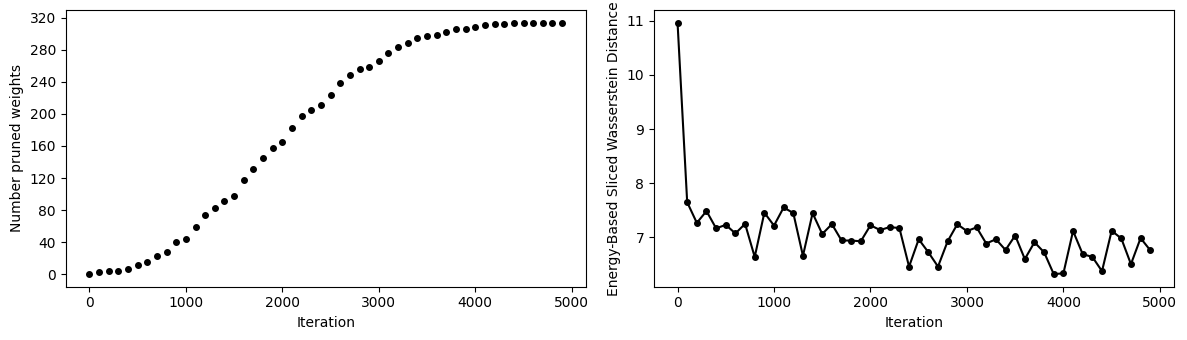

In [18]:
# Visualize progression of the prior optimization
num_iters_ps = prior_opt_configurations["num_iters"]
loss_hist = np.loadtxt(loss_path)
p_hist = np.loadtxt(pruned_path)

indices = np.arange(num_iters_ps)[::100]

fig, axes = plt.subplots(1, 2, figsize=(12, 3.5))  
axes[0].plot(indices, p_hist[indices], "ko", ms=4)
axes[0].set_ylabel("Number pruned weights")
axes[0].set_xlabel("Iteration")
axes[0].yaxis.set_major_locator(ticker.MaxNLocator(integer=True))

axes[1].plot(indices, loss_hist[indices], "-ko", ms=4)
axes[1].set_ylabel("Energy-Based Sliced Wasserstein Distance")
axes[1].set_xlabel("Iteration")

plt.tight_layout()
plt.show()

## Optimize the prior for full stochasticity

### Wasserstein distance

In [19]:
mapper_num_iters = 800 # Define the number of iterations of Wasserstein optimization

In [20]:
# Prior to be optimized 
opt_bnn = GaussianMLPReparameterization(input_dim=1, output_dim=1, activation_fn=transfer_fn, 
    hidden_dims=[width]*depth)
opt_bnn = opt_bnn.to(device)
# Fixed prior
fixed_bnn_fs = GaussianMLPReparameterization(input_dim=1, output_dim=1, activation_fn=transfer_fn, 
    hidden_dims=[width]*depth)
fixed_bnn_fs = fixed_bnn_fs.to(device)

In [21]:
# Initiialize the Wasserstein optimizer
util.set_seed(1)
mapper = MapperWasserstein(gpmodel_fs, opt_bnn, data_generator,
                           out_dir=OUT_DIR_FS, 
                           wasserstein_steps=(0, 1000),
                           wasserstein_lr=0.08,
                           n_data=200, n_gpu=1, gpu_gp=True)

# Start optimizing the prior
w_hist = mapper.optimize(num_iters=mapper_num_iters, n_samples=512, lr=0.01, 
                         save_ckpt_every=50, print_every=20, debug=True)
wsr_path = os.path.join(OUT_DIR_FS, "wsr_values.log")
np.savetxt(wsr_path, w_hist, fmt='%.6e')       

>>> Iteration #   1: Wasserstein Dist 32.7536
>>> Iteration #  20: Wasserstein Dist 21.1113
>>> Iteration #  40: Wasserstein Dist 16.8200
>>> Iteration #  60: Wasserstein Dist 14.3601
>>> Iteration #  80: Wasserstein Dist 13.4305
>>> Iteration # 100: Wasserstein Dist 11.6732
>>> Iteration # 120: Wasserstein Dist 11.2703
>>> Iteration # 140: Wasserstein Dist 11.0067
>>> Iteration # 160: Wasserstein Dist 10.1051
>>> Iteration # 180: Wasserstein Dist 10.1815
>>> Iteration # 200: Wasserstein Dist 9.4576
>>> Iteration # 220: Wasserstein Dist 9.5216
>>> Iteration # 240: Wasserstein Dist 9.5580
>>> Iteration # 260: Wasserstein Dist 9.0121
>>> Iteration # 280: Wasserstein Dist 9.5519
>>> Iteration # 300: Wasserstein Dist 8.5128
>>> Iteration # 320: Wasserstein Dist 9.3226
>>> Iteration # 340: Wasserstein Dist 9.0474
>>> Iteration # 360: Wasserstein Dist 8.2227
>>> Iteration # 380: Wasserstein Dist 8.1019
>>> Iteration # 400: Wasserstein Dist 7.9863
>>> Iteration # 420: Wasserstein Dist 8.3936


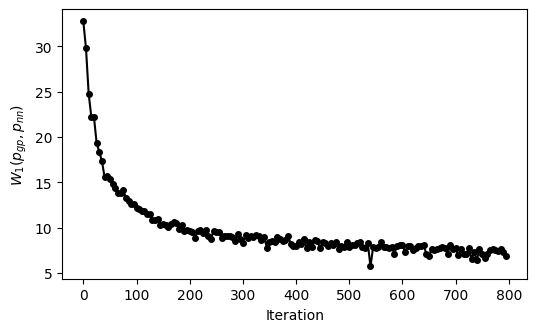

In [22]:
# Visualize progression of the prior optimization
wdist_file = os.path.join(OUT_DIR_FS, "wsr_values.log")
wdist_vals = np.loadtxt(wdist_file)

fig = plt.figure(figsize=(6, 3.5))
indices = np.arange(mapper_num_iters)[::5]
plt.plot(indices, wdist_vals[indices], "-ko", ms=4)
plt.ylabel(r"$W_1(p_{gp}, p_{nn})$")
plt.xlabel("Iteration")
plt.show()

## Compare Functional Prior

In [23]:
# Load the optimize priors
util.set_seed(1)
ckpt_path_fs = os.path.join(OUT_DIR_FS, "ckpts", "it-{}.ckpt".format(mapper_num_iters))
opt_bnn.load_state_dict(torch.load(ckpt_path_fs))

<All keys matched successfully>

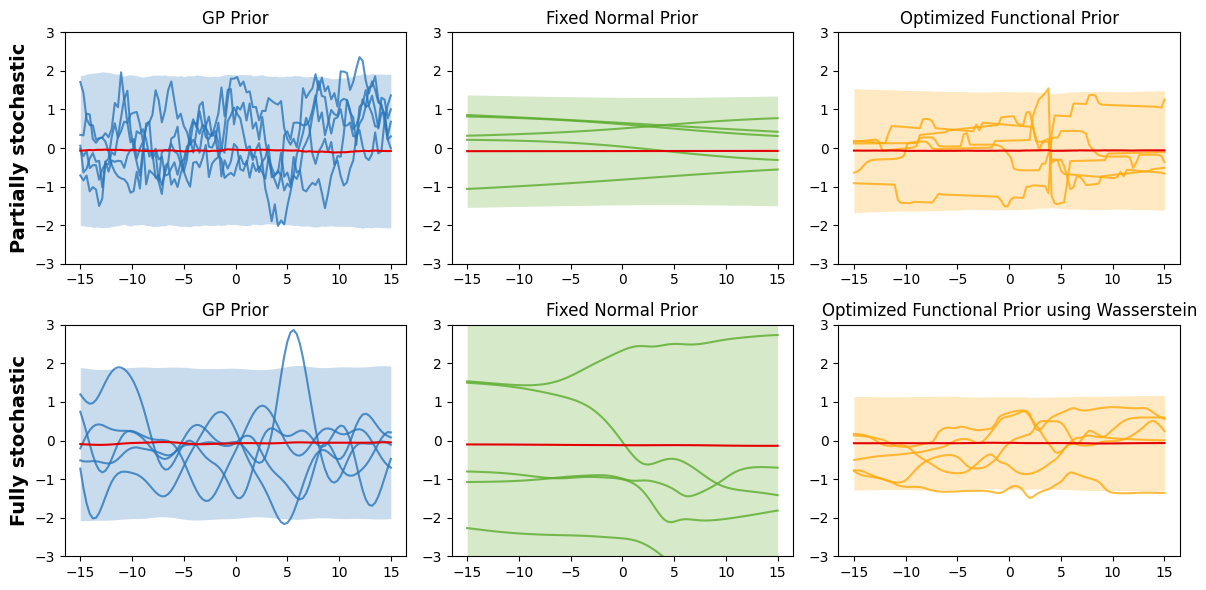

In [24]:
# Draw functions from the priors
util.set_seed(8)
n_plot = 4000

fixed_bnn_samples_ps = fixed_bnn_ps.sample_functions(
    Xtest_tensor.float(), n_plot).detach().cpu().numpy().squeeze()
fixed_bnn_samples_ps = zscore_unnormalization(fixed_bnn_samples_ps, y_mean, y_std)

sparse_opt_samples = opt_bnn_sparse.sample_functions(
    Xtest_tensor.float(), n_plot).detach().cpu().numpy().squeeze()
sparse_opt_samples = zscore_unnormalization(sparse_opt_samples, y_mean, y_std)

opt_samples_wsr = opt_bnn.sample_functions(
    Xtest_tensor.float(), n_plot).detach().cpu().numpy().squeeze()
opt_samples_wsr = zscore_unnormalization(opt_samples_wsr, y_mean, y_std)

fixed_bnn_samples_fs = fixed_bnn_fs.sample_functions(
    Xtest_tensor.float(), n_plot).detach().cpu().numpy().squeeze()
fixed_bnn_samples_fs = zscore_unnormalization(fixed_bnn_samples_fs, y_mean, y_std)

gp_samples_ps = gpmodel_ps.sample_functions(
   Xtest_tensor, n_plot).detach().cpu().numpy().squeeze()
gp_samples_ps = zscore_unnormalization(gp_samples_ps, y_mean, y_std)

gp_samples_fs = gpmodel_fs.sample_functions(
   Xtest_tensor, n_plot).detach().cpu().numpy().squeeze()
gp_samples_fs = zscore_unnormalization(gp_samples_fs, y_mean, y_std)

fig, axs = plt.subplots(2,3, figsize=(12, 6))

plot_samples(Xtest, gp_samples_ps, ax=axs[0,0], n_keep=5)
axs[0,0].set_title('GP Prior')
axs[0,0].set_ylim([-3,3])

plot_samples(Xtest, fixed_bnn_samples_ps,color='xkcd:grass',  ax=axs[0,1], n_keep=5)
axs[0,1].set_title('Fixed Normal Prior')
axs[0,1].set_ylim([-3,3])

plot_samples(Xtest, sparse_opt_samples, ax=axs[0,2], color='xkcd:yellowish orange', n_keep=5)
axs[0,2].set_title('Optimized Functional Prior')
axs[0,2].set_ylim([-3,3])

plot_samples(Xtest, gp_samples_fs, ax=axs[1,0], n_keep=5)
axs[1,0].set_title('GP Prior')
axs[1,0].set_ylim([-3,3])

plot_samples(Xtest, fixed_bnn_samples_fs,color='xkcd:grass',  ax=axs[1,1], n_keep=5)
axs[1,1].set_title('Fixed Normal Prior')
axs[1,1].set_ylim([-3,3])

plot_samples(Xtest, opt_samples_wsr, ax=axs[1,2], color='xkcd:yellowish orange', n_keep=5)
axs[1,2].set_title('Optimized Functional Prior using Wasserstein')
axs[1,2].set_ylim([-3,3])

axs[0,0].set_ylabel('Partially stochastic', fontsize=14, weight='bold')
axs[1,0].set_ylabel('Fully stochastic', fontsize=14, weight='bold')

plt.tight_layout()
plt.show()

# Posterior Inference

In [25]:
# SGHMC Hyper-parameters
sampling_configs_ps = {
    "batch_size": 16,            # Mini-batch size
    "num_samples": 30,           # Total number of samples for each chain
    "n_discarded": 10,           # Number of the first samples to be discared for each chain
    "num_burn_in_steps": 1500,   # Number of burn-in steps, 2000 yields better MSE
    "keep_every": 200,           # Thinning interval
    "lr": 0.02,                  # Step size
    "num_chains": 4,             # Number of chains
    "mdecay": 0.015,             # Momentum coefficient
    "print_every_n_samples": 5,  # After how many iterations an evaluation should be printed
    "lambd": 5e-8,               # The lambda for encouraging sparsity in the deterministic weights
    "train_det_before": 1000     # How many iterations the deterministic weights should be trained prior to sampling from the posterior
}

with open(os.path.join(OUT_DIR_PS, "masks_list.pkl"), "rb") as f:
    weights_mask_ps, bias_mask_ps = pickle.load(f)

## Optimized prior partially stochastic

In [26]:
# Load the optimized prior
util.set_seed(1)
ckpt_path_sparse = os.path.join(OUT_DIR_PS, "ckpts", "ps-it-{}.ckpt".format(num_iters_ps))
prior_optim_sparse = OptimGaussianPrior(ckpt_path_sparse)

# Setup likelihood and network
likelihood = LikGaussian(sn2)
net_optim_ps = MLPMasked(1, 1, [width]*depth, transfer_fn, weights_mask_ps, bias_mask_ps, D = D, device=device)
# Initialize the sampler
saved_dir = os.path.join(OUT_DIR_PS, "sampling_optim")
util.ensure_dir(saved_dir)
ps_net_optim = RegressionNetMasked(net_optim_ps, likelihood, prior_optim_sparse, saved_dir, n_gpu=n_gpu)
# Start sampling
ps_net_optim.sample_multi_chains(X, y, **sampling_configs_ps)

Chain: 1
Samples #     5 : NLL =  2.6769e-01 RMSE = 2.5648e-01  
 Pruned deterministic weights: 0
Samples #    10 : NLL =  2.5718e-01 RMSE = 2.4629e-01  
 Pruned deterministic weights: 0
Samples #    15 : NLL =  2.4953e-01 RMSE = 2.3344e-01  
 Pruned deterministic weights: 0
Samples #    20 : NLL =  2.4982e-01 RMSE = 2.3130e-01  
 Pruned deterministic weights: 0
Chain: 2
Samples #    25 : NLL =  2.5302e-01 RMSE = 2.3149e-01  
 Pruned deterministic weights: 8
Samples #    30 : NLL =  2.5370e-01 RMSE = 2.3109e-01  
 Pruned deterministic weights: 8
Samples #    35 : NLL =  2.5049e-01 RMSE = 2.3026e-01  
 Pruned deterministic weights: 8
Samples #    40 : NLL =  2.5141e-01 RMSE = 2.3082e-01  
 Pruned deterministic weights: 8
Chain: 3
Samples #    45 : NLL =  2.5488e-01 RMSE = 2.3213e-01  
 Pruned deterministic weights: 46
Samples #    50 : NLL =  2.5675e-01 RMSE = 2.3090e-01  
 Pruned deterministic weights: 46
Samples #    55 : NLL =  2.5598e-01 RMSE = 2.3087e-01  
 Pruned deterministic wei

In [27]:
# Make predictions
_, _, ps_optim_preds = ps_net_optim.predict(Xtest, True)

# Convergence diagnostics using the R-hat statistic
r_hat = compute_rhat_regression(ps_optim_preds, sampling_configs_ps["num_chains"])
print(r"R-hat: mean {:.4f} std {:.4f}".format(float(r_hat.mean()), float(r_hat.std())))
ps_optim_preds = ps_optim_preds.squeeze().T

# Save the predictions
posterior_optim_path = os.path.join(OUT_DIR_PS, "posterior_optim.npz")
np.savez(posterior_optim_path, bnn_samples=ps_optim_preds)

R-hat: mean 1.0642 std 0.0616


## Fixed prior partially stochastic

In [28]:
# Find the fixed prior
util.set_seed(1)
prior_fixed = FixedGaussianPrior(std=1.0)
# Setup network
net_fixed_ps = MLPMasked(1, 1, [width]*depth, transfer_fn, weights_mask_ps, bias_mask_ps, D = D, device=device)
# Initialize the sampler
saved_dir = os.path.join(OUT_DIR_PS, "sampling_fixed")
util.ensure_dir(saved_dir)
ps_net_fixed = RegressionNetMasked(net_fixed_ps, likelihood, prior_fixed, saved_dir, n_gpu=n_gpu)
# Start sampling
ps_net_fixed.sample_multi_chains(X, y, **sampling_configs_ps)

Chain: 1
Samples #     5 : NLL =  2.6440e-01 RMSE = 2.7762e-01  
 Pruned deterministic weights: 0
Samples #    10 : NLL =  2.7094e-01 RMSE = 2.7781e-01  
 Pruned deterministic weights: 0
Samples #    15 : NLL =  2.6566e-01 RMSE = 2.7329e-01  
 Pruned deterministic weights: 0
Samples #    20 : NLL =  2.6605e-01 RMSE = 2.7147e-01  
 Pruned deterministic weights: 0
Chain: 2
Samples #    25 : NLL =  2.6624e-01 RMSE = 2.7099e-01  
 Pruned deterministic weights: 8
Samples #    30 : NLL =  2.6302e-01 RMSE = 2.6999e-01  
 Pruned deterministic weights: 8
Samples #    35 : NLL =  2.6000e-01 RMSE = 2.6817e-01  
 Pruned deterministic weights: 8
Samples #    40 : NLL =  2.6107e-01 RMSE = 2.6818e-01  
 Pruned deterministic weights: 8
Chain: 3
Samples #    45 : NLL =  2.5950e-01 RMSE = 2.6711e-01  
 Pruned deterministic weights: 46
Samples #    50 : NLL =  2.5855e-01 RMSE = 2.6632e-01  
 Pruned deterministic weights: 46
Samples #    55 : NLL =  2.5708e-01 RMSE = 2.6594e-01  
 Pruned deterministic wei

In [29]:
# Make predictions
_, _, ps_fixed_preds = ps_net_fixed.predict(Xtest, True)

# Convergence diagnostics using the R-hat statistic
r_hat = compute_rhat_regression(ps_fixed_preds, sampling_configs_ps["num_chains"])
print(r"R-hat: mean {:.4f} std {:.4f}".format(float(r_hat.mean()), float(r_hat.std())))
ps_fixed_preds = ps_fixed_preds.squeeze().T

# Save the predictions
posterior_optim_path = os.path.join(OUT_DIR_PS, "posterior_fixed.npz")
np.savez(posterior_optim_path, bnn_samples=ps_fixed_preds)

R-hat: mean 1.0619 std 0.0927


## Optimized Prior full stochasticity

In [30]:
# SGHMC Hyper-parameters
sampling_configs_fs = {
    "batch_size": 32,           # Mini-batch size
    "num_samples": 30,          # Total number of samples for each chain
    "n_discarded": 10,          # Number of the first samples to be discared for each chain
    "num_burn_in_steps": 2000,  # Number of burn-in steps, 2000 yields better MSE
    "keep_every": 200,          # Thinning interval
    "lr": 0.01,                 # Step size
    "num_chains": 4,            # Number of chains
    "mdecay": 0.01,             # Momentum coefficient
    "print_every_n_samples": 5
}

In [31]:
# Load the optimized prior
util.set_seed(1)
ckpt_path_fs = os.path.join(OUT_DIR_FS, "ckpts", "it-{}.ckpt".format(mapper_num_iters))
prior_optim_fs = OptimGaussianPrior(ckpt_path_fs)

# Setup likelihood and network
likelihood = LikGaussian(sn2)
net_optim_fs = MLP(1, 1, [width]*depth, transfer_fn)
# Initialize the sampler
saved_dir = os.path.join(OUT_DIR_FS, "sampling_optim")
util.ensure_dir(saved_dir)
fs_net_optim = RegressionNet(net_optim_fs, likelihood, prior_optim_fs, saved_dir, n_gpu=n_gpu)
# Start sampling
fs_net_optim.sample_multi_chains(X, y, **sampling_configs_fs)

Chain: 0
Samples #     5 : NLL =  2.7649e-01 RMSE = 2.7806e-01 
Samples #    10 : NLL =  2.8376e-01 RMSE = 2.8004e-01 
Samples #    15 : NLL =  2.8762e-01 RMSE = 2.8316e-01 
Samples #    20 : NLL =  2.8350e-01 RMSE = 2.7807e-01 
Chain: 1
Samples #    25 : NLL =  2.8442e-01 RMSE = 2.7981e-01 
Samples #    30 : NLL =  2.8183e-01 RMSE = 2.7909e-01 
Samples #    35 : NLL =  2.8291e-01 RMSE = 2.7838e-01 
Samples #    40 : NLL =  2.8347e-01 RMSE = 2.7762e-01 
Chain: 2
Samples #    45 : NLL =  2.8423e-01 RMSE = 2.7817e-01 
Samples #    50 : NLL =  2.8637e-01 RMSE = 2.7938e-01 
Samples #    55 : NLL =  2.8679e-01 RMSE = 2.7985e-01 
Samples #    60 : NLL =  2.8835e-01 RMSE = 2.8091e-01 
Chain: 3
Samples #    65 : NLL =  2.8822e-01 RMSE = 2.8096e-01 
Samples #    70 : NLL =  2.8833e-01 RMSE = 2.8138e-01 
Samples #    75 : NLL =  2.8730e-01 RMSE = 2.8116e-01 
Samples #    80 : NLL =  2.8707e-01 RMSE = 2.8105e-01 


In [32]:
# Make predictions
_, _, fs_optim_preds = fs_net_optim.predict(Xtest, True)

# Convergence diagnostics using the R-hat statistic
r_hat = compute_rhat_regression(fs_optim_preds, sampling_configs_fs["num_chains"])
print(r"R-hat: mean {:.4f} std {:.4f}".format(float(r_hat.mean()), float(r_hat.std())))
fs_optim_preds = fs_optim_preds.squeeze().T

# Save the predictions
posterior_optim_path = os.path.join(OUT_DIR_FS, "posterior_optim.npz")
np.savez(posterior_optim_path, bnn_samples=fs_optim_preds)

R-hat: mean 0.9972 std 0.0134


## Fixed prior full stochasticity

In [33]:
# Setup network
net_fixed_fs = MLP(1, 1, [width]*depth, transfer_fn)
# Initialize the sampler
saved_dir = os.path.join(OUT_DIR_FS, "sampling_fixed")
util.ensure_dir(saved_dir)
fs_net_fixed = RegressionNet(net_fixed_fs, likelihood, prior_fixed, saved_dir, n_gpu=n_gpu)
# Start sampling
fs_net_fixed.sample_multi_chains(X, y, **sampling_configs_fs)

Chain: 0
Samples #     5 : NLL =  4.1711e-01 RMSE = 3.5829e-01 
Samples #    10 : NLL =  4.3402e-01 RMSE = 3.6837e-01 
Samples #    15 : NLL =  4.6743e-01 RMSE = 3.8547e-01 
Samples #    20 : NLL =  4.6456e-01 RMSE = 3.8354e-01 
Chain: 1
Samples #    25 : NLL =  4.6278e-01 RMSE = 3.8193e-01 
Samples #    30 : NLL =  4.5963e-01 RMSE = 3.8067e-01 
Samples #    35 : NLL =  4.4954e-01 RMSE = 3.7620e-01 
Samples #    40 : NLL =  4.4751e-01 RMSE = 3.7496e-01 
Chain: 2
Samples #    45 : NLL =  4.5609e-01 RMSE = 3.7883e-01 
Samples #    50 : NLL =  4.5440e-01 RMSE = 3.7790e-01 
Samples #    55 : NLL =  4.5963e-01 RMSE = 3.8033e-01 
Samples #    60 : NLL =  4.6571e-01 RMSE = 3.8312e-01 
Chain: 3
Samples #    65 : NLL =  4.6734e-01 RMSE = 3.8361e-01 
Samples #    70 : NLL =  4.6523e-01 RMSE = 3.8259e-01 
Samples #    75 : NLL =  4.6226e-01 RMSE = 3.8145e-01 
Samples #    80 : NLL =  4.6465e-01 RMSE = 3.8257e-01 


In [34]:
# Make predictions
_, _, fs_fixed_preds = fs_net_fixed.predict(Xtest, True)

# Convergence diagnostics using the R-hat statistic
r_hat = compute_rhat_regression(fs_fixed_preds, sampling_configs_fs["num_chains"])
print(r"R-hat: mean {:.4f} std {:.4f}".format(float(r_hat.mean()), float(r_hat.std())))
fs_fixed_preds = fs_fixed_preds.squeeze().T

# Save the predictions
posterior_optim_path = os.path.join(OUT_DIR_FS, "posterior_optim_fixed.npz")
np.savez(posterior_optim_path, bnn_samples=fs_fixed_preds)

R-hat: mean 1.0030 std 0.0193


# Visualize Predictive Posterior

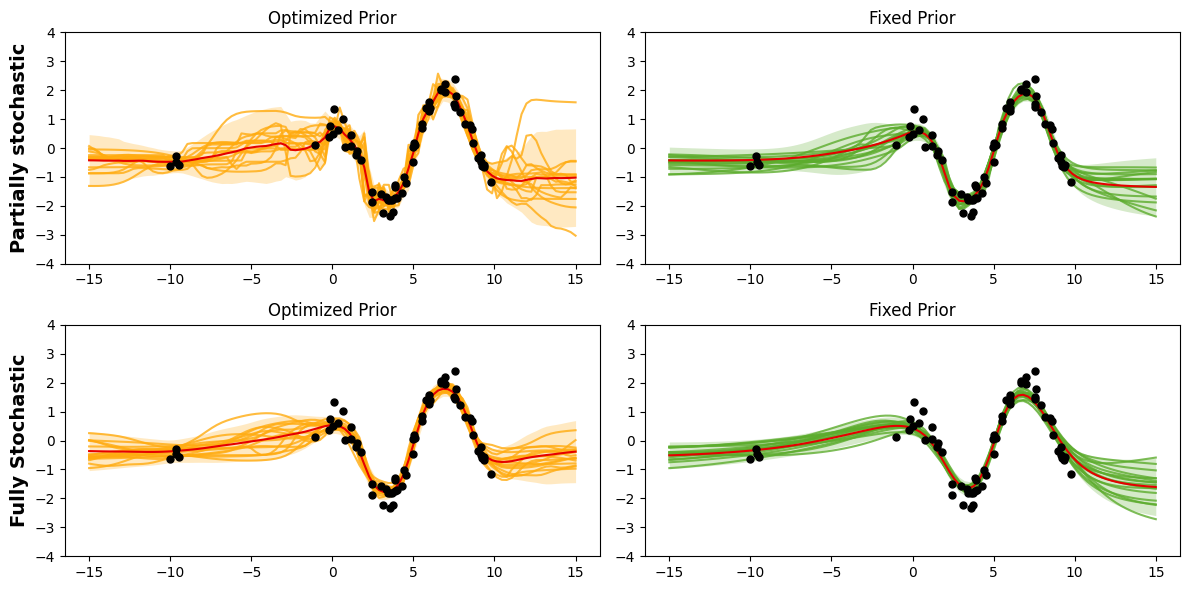

In [35]:
util.set_seed(3)

fig, axs = plt.subplots(2,2, figsize=(12, 6))
plot_samples(Xtest, ps_optim_preds, ax = axs[0,0], color='xkcd:yellowish orange', n_keep=16)
axs[0,0].plot(X, y, 'ok', zorder=10, ms=5)
axs[0,0].set_title('Optimized Prior')
axs[0,0].set_ylim([-4, 4])

plot_samples(Xtest, ps_fixed_preds, ax = axs[0,1], color='xkcd:grass', n_keep=16)
axs[0,1].plot(X, y, 'ok', zorder=10, ms=5)
axs[0,1].set_title('Fixed Prior')
axs[0,1].set_ylim([-4, 4])

plot_samples(Xtest, fs_optim_preds, ax = axs[1,0], color='xkcd:yellowish orange', n_keep=16)
axs[1,0].plot(X, y, 'ok', zorder=10, ms=5)
axs[1,0].set_title('Optimized Prior')
axs[1,0].set_ylim([-4, 4])

plot_samples(Xtest, fs_fixed_preds, ax = axs[1,1], color='xkcd:grass', n_keep=16)
axs[1,1].plot(X, y, 'ok', zorder=10, ms=5)
axs[1,1].set_title('Fixed Prior')
axs[1,1].set_ylim([-4, 4])

# Add row labels as y-axis labels
axs[0,0].set_ylabel('Partially stochastic', fontsize=14, weight='bold')
axs[1,0].set_ylabel('Fully Stochastic', fontsize=14, weight='bold')


plt.tight_layout()
plt.show()